# SOMPZ
### The purpose of this notebook is to take a wide, deep and balrog catalogs and create N(z)'s

### 1. Load packages

In [1]:
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import pickle as pkl
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import scipy
from scipy.optimize import differential_evolution
from matplotlib.colors import LogNorm
outpath = '/project/chihway/raulteixeira/data/'
n_deep, n_wide = 48, 26
nbins = 50
zmin, zmax = 0., 2.
deltaz = (zmax-zmin)/nbins
assert ((zmin>=0) & (zmax>=zmin) & (nbins>0) & (n_deep>0) & (n_wide>0))
z_edges = np.linspace(zmin,zmax,nbins) #np.arange(zmin,zmax,deltaz)
zs = .5*np.array([z_edges[i]+z_edges[i+1] for i in range(nbins-1)])

### 2. load functions

In [2]:
#add descriptions to functions!!!

# def hist(a):
#     '''
#     Returns the counts of each bin in a histogram of sample a (numerical list-like object)
#     '''
#     return list(np.histogram(a, bins=z_edges, density=False)[0])

def hist(group):
    '''
    Returns the counts of each bin in a histogram of sample a (numerical list-like object)
    '''
    return list(np.histogram(group.Z, bins=z_edges, density=False, weights=group.w)[0])

def flux2mag(flux):
    '''
    Converts fluxes to magnitudes
    '''
    return -2.5 * np.log10(flux) + 30

### 3. Load relevant catalogs (wide, deep, balrog), apply relevant cuts and add relevant columns

In [3]:
wide = np.load('%sBPZ+SOM_mcal_gold_wide_26x26_ids+cells+fluxes.npz'%outpath)['arr_0']
# opens .npz containing BPZ estimates, wide SOM cell assignments, ids, and fluxes. 
# Catalog has foreground, wl selection, and gold cut applied already.
wide = pd.DataFrame(wide) #convert to pandas dataframe for easier data manipulation
wide['wide_cells']=wide['cells'] #rename 'cells' column for easier identification
wide.drop(columns=['cells']) #see comment above

MemoryError: Unable to allocate 2.12 GiB for an array with shape (6, 47341776) and data type float64

MemoryError: Unable to allocate 722. MiB for an array with shape (2, 47341776) and data type int64

In [4]:
deep_cells = np.load('%s/som_DES_DF_balrog_gold+wl+fg_112623_48x48.npz'%outpath)['cells']
deep = pd.read_hdf('%s/deep_Balrog_DR3_1_1_fp_GOLD_WL_FG.hdf5'%outpath, key='df')
deep['deep_cells'] = deep_cells

In [5]:
for band in list('UGRIZJH')+['KS']:

    fluxcol = f'BDF_FLUX_DERED_CALIB_{band}'
    fluxerrcol = f'BDF_FLUX_ERR_DERED_CALIB_{band}'
    
    magcol = f'BDF_MAG_DERED_CALIB_{band}'
    magerrcol = f'BDF_MAG_ERR_DERED_CALIB_{band}'

    deep[magcol]=flux2mag(deep[fluxcol])
    deep[magerrcol]=flux2mag(deep[fluxerrcol])

In [6]:
#deep.to_hdf('%s/deep_Balrog_DR3_1_1_fp_GOLD_WL_FG_deep_cells.hdf5'%outpath, key='df')

In [7]:
np.isfinite(deep['Z']).sum()

55084

In [8]:
balrog = pd.read_hdf('%s/BalrogoftheDECADE_112523_wide_cells.hdf5'%outpath, key='df')
balrog_mask = np.load('/project/chihway/raulteixeira/data/Balrog_20231125_MASK_GOLD+WL+FG.npz')['arr_0']

# zeroth order masks
balrog_fg_mask = balrog['FLAGS_FOREGROUND']==0
d_contam_arcsec  = balrog['d_contam_arcsec']
contmask = balrog['d_contam_arcsec'] > 1.5 #(d_contam_arcsec > 1.5) 
balrog['contmask'] = balrog['d_contam_arcsec'] > 1.5 #contmask
balrog_fp_mask = (balrog['true_ra'] < 180) & (balrog['true_dec'] > -25) #footprint mask for DR3_1_1

usable_balmask = balrog_fg_mask&contmask&balrog_fp_mask
# add balrog dr3_1_1 footprint cut

print(f'fraction of usable balrog injections that pass the gold cut and WL selection:\
      {np.mean(balrog_mask[usable_balmask]):.2}')

balrog = balrog[usable_balmask] #applying DR3_1_1 footprint mask, contamination mask
balrog_mask_test = balrog_mask[usable_balmask]

fraction of usable balrog injections that pass the gold cut and WL selection:      0.22


In [9]:
balrog['passes'] = balrog_mask[usable_balmask]
print(len(balrog)) #length of balrog after usable mask

balrog_deep = balrog.merge(deep, on='ID', how='left') # merge balrog w/ deep catalog for later
                                                      # will have same length as barlog catalog

3760727


In [10]:
balrog_deep['ID'][balrog_deep.passes]

7          712506387
12         692225355
18         713123920
20         712899060
22         697521341
             ...    
3760678    712363856
3760704    699788667
3760712    692042454
3760715    699486268
3760716    698444945
Name: ID, Length: 834737, dtype: int64

In [11]:
balrog['ID'][balrog.passes.values]

249651     712506387
249656     692225355
249663     713123920
249665     712899060
249671     697521341
             ...    
5623486    712363856
5623512    699788667
5623521    692042454
5623525    699486268
5623526    698444945
Name: ID, Length: 834737, dtype: int64

In [12]:
(balrog_deep['detected']&balrog['passes']).sum()

304252

In [13]:
((balrog_deep['detected']&balrog['passes'])==balrog_deep['passes']).all()

ValueError: Can only compare identically-labeled Series objects

### contaminant cut (moved to where the balrog cat. is loaded)

### estimating the probability of a given galaxy in the deep fields making a detection
* Note here that we are obtaining 'counts_dec' not with 'detected' column but with gold cut (double check this is correct!)

In [14]:
unique_ids, counts_true = np.unique(balrog.ID.values, return_counts=True) 
# how many injections for each DF galaxy were made

unique_ids_detected, counts_detected = np.unique(balrog.ID.values[balrog.passes.values], return_counts=True)
# how many gold "detections" for each DF galaxy were made

# pandas to simplify life
df0 = pd.DataFrame()
df0['ID'] = unique_ids
df0['counts_ins'] = counts_true

df1 = pd.DataFrame()
df1['ID'] = unique_ids_detected
df1['counts_dec'] = counts_detected

df_ = df0.merge(df1, on='ID', how='left') 
# merge on id, this dataframe, df_, will have length equal to 
# the number of DF galaxies being used for balrog injections

df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed, 
                                                   # I can probably do this on the array to not get a warning

df_['p_pass'] = df_['counts_dec']/df_['counts_ins'] 
#p(\hat{c}) i.e., probability of passing for a given DF galaxy

balrog = balrog.merge(df_[['ID', 'p_pass']], on='ID') 
# merging to have everything under balrog and be able
# to make cell statistics of the columns generated in this cell

/tmp/jobs/31869173/ipykernel_101076/407432572.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed,


### Create and marginalize probabilities to obtain Balrog Transfer Matrix

In [15]:
(balrog.passes.values&balrog.detected.values.astype(bool)).sum()

834737

In [16]:
(balrog.passes.values&balrog.detected.values.astype(bool) == balrog.passes.values).all()

True

In [17]:
# !!!

# *Relevant* for this cell: section 5 and Appendix D in Myles, Alarcon, et. al 2021

#p(c) - i.e. probability that a galaxy in the deep fields will belong to a cell c
square_len_deep = balrog_deep[['BDF_FLUX_DERED_CALIB_I', 'deep_cells']].groupby('deep_cells').agg(['mean', 'median', 'std', len])
counts_deep = square_len_deep.BDF_FLUX_DERED_CALIB_I.len
p_c = (counts_deep/counts_deep.sum()).values.reshape(n_deep,n_deep)

#square_wide = wide['wide_cells'].groupby('wide_cells').agg(['mean', 'median', 'std', len])

#p(\hat{c}) - i.e. probability that a galaxy in the wide fields will belong to a cell c 
square_p_c_hat = wide[['COADD_OBJECT_ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide = square_p_c_hat.COADD_OBJECT_ID.len

#p^W(\hat{c}) - Wide field version
p_c_hat = counts_wide.values.reshape(n_wide,n_wide)
p_c_hat = p_c_hat/np.sum(p_c_hat)

# #p^B(\hat{c}) - Balrog version - see if detection masking is appropriate here 
#                                 # that is, should we include this or not? [balrog.detected.values.astype(bool)]
# square_p_c_hat_bal = balrog_deep[balrog_deep.passes.values&np.isfinite(balrog_deep.deep_cells.values)]\
# [['ID', 'wide_cells']].groupby('wide_cells').agg([len])

# counts_wide_bal = square_p_c_hat_bal.ID.len

# p_c_hat_bal = counts_wide_bal.values.reshape(n_wide,n_wide).astype(np.float64)
# p_c_hat_bal /= np.sum(p_c_hat_bal)

In [18]:
balrog_deep[balrog_deep.passes.values&np.isfinite(balrog_deep.deep_cells.values)]

,mcal_flux_r_noshear,mcal_flux_r_err_noshear,mcal_flux_i_noshear,mcal_flux_i_err_noshear,mcal_flux_z_noshear,mcal_flux_z_err_noshear,g1,g2,FLAGS_FOREGROUND,ID,...,BDF_MAG_DERED_CALIB_I,BDF_MAG_ERR_DERED_CALIB_I,BDF_MAG_DERED_CALIB_Z,BDF_MAG_ERR_DERED_CALIB_Z,BDF_MAG_DERED_CALIB_J,BDF_MAG_ERR_DERED_CALIB_J,BDF_MAG_DERED_CALIB_H,BDF_MAG_ERR_DERED_CALIB_H,BDF_MAG_DERED_CALIB_KS,BDF_MAG_ERR_DERED_CALIB_KS
7,1170.658381,43.246469,1891.608479,59.952772,2666.375662,138.148313,0.090913,0.054868,0,712506387,...,21.793472,26.914453,21.615287,26.416893,21.207140,26.792984,20.988612,26.542700,20.777399,26.250448
12,3912.820410,47.545158,6801.066309,81.169653,9267.494833,121.945083,0.039710,0.006077,0,692225355,...,20.160686,25.776673,19.851423,25.206552,19.385809,25.587717,19.063178,25.259820,18.774048,24.745863
18,2276.154044,46.028903,3330.801358,72.281310,4135.634128,180.193282,0.117365,0.016887,0,713123920,...,21.047823,26.610792,20.964626,26.197608,20.614012,26.819561,20.449973,26.520665,20.254929,26.180420
20,2313.586933,43.925832,3821.015298,70.232383,5610.432617,131.026595,0.203675,-0.494443,0,712899060,...,20.795582,26.473708,20.483253,25.926905,19.893622,25.308880,19.401800,24.949056,18.994396,24.577074
22,2515.529433,47.234600,4407.703932,80.735896,5702.351392,112.469789,0.303352,-0.058228,0,697521341,...,21.057478,26.629402,20.686939,26.014371,20.130733,25.199586,19.679149,24.827667,19.352220,24.496160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760678,809.948794,50.793287,1383.708870,71.224642,2403.683192,111.280986,0.023843,-0.044111,0,712363856,...,22.126367,27.159149,21.511570,26.598360,20.977613,27.338155,20.681840,27.047122,20.293194,26.434957
3760704,1851.996860,42.130149,3152.516113,79.114255,4823.861290,108.494352,-0.215791,-0.210357,0,699788667,...,20.936358,25.495980,20.526133,25.013358,19.958419,25.270633,19.536986,25.050601,19.252051,24.788992
3760712,3021.648666,92.003222,3827.579619,72.460554,4315.782233,121.657282,-0.371455,-0.421217,0,692042454,...,20.938800,26.236383,20.710953,25.613858,20.412311,26.245940,20.195041,25.638029,19.962281,25.514280
3760715,1414.834473,68.806698,2219.440566,59.953218,2603.427900,85.606904,0.154541,0.288719,0,699486268,...,21.691790,26.795586,21.481357,26.312145,21.168877,25.354920,21.149502,25.477576,20.896798,25.193250


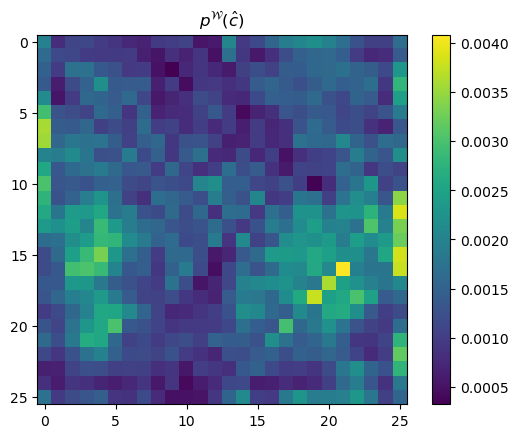

In [19]:
plt.title('$p^{\mathcal{W}}(\hat{c})$')
plt.imshow(p_c_hat)
plt.colorbar()

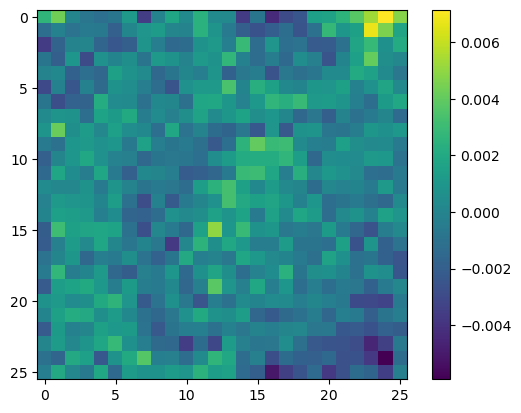

In [20]:
plt.imshow(((np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_chat.npy')-p_c_hat.flatten())/p_c_hat.flatten()).reshape(26,26))
plt.colorbar()

In [21]:
p_chat_dhayaa_v3 = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_chat_V3.npy').flatten()
p_chat_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_chat.npy').flatten()

In [22]:
np.allclose(p_chat_dhayaa_v3, p_c_hat.flatten())

True

In [23]:
np.allclose((p_chat_dhayaa-p_c_hat.flatten())/p_c_hat.flatten(), (p_chat_dhayaa-p_chat_dhayaa_v3)/p_chat_dhayaa_v3)

True

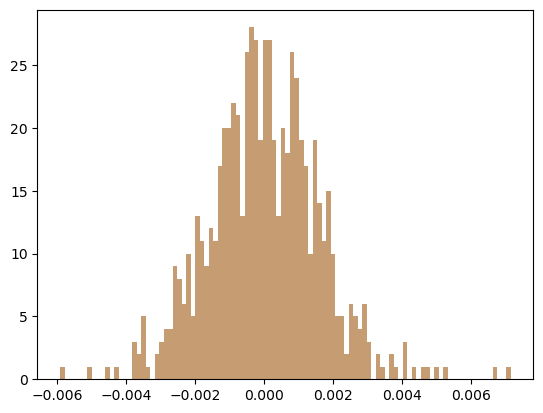

In [24]:
hist1 = plt.hist((p_chat_dhayaa-p_chat_dhayaa_v3)/p_chat_dhayaa_v3, alpha=.5, bins=100)
hist2 = plt.hist((p_chat_dhayaa-p_c_hat.flatten())/p_c_hat.flatten(), alpha=.5, bins=100)

In [25]:
hist1[0]-hist2[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

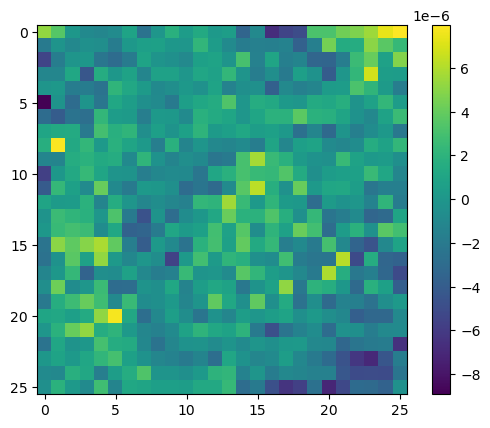

In [26]:
plt.imshow(((p_chat_dhayaa.flatten()-p_c_hat.flatten())).reshape(26,26))
plt.colorbar()

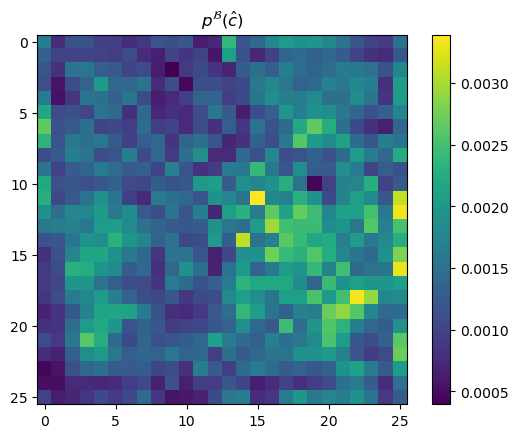

In [27]:
plt.title('$p^{\mathcal{B}}(\hat{c})$')
plt.imshow(p_c_hat_bal)
plt.colorbar()

In [29]:
(balrog_deep.passes!=balrog.passes).sum()

1304410

In [30]:
# #p(c,\hat{c}) - joint probability of a galaxy in balrog_deep being in cell c and \hat{c}
# N_wide, N_deep = 26**2, 48**2
# #sel_mask = balrog_deep.detected&balrog_deep.passes&balrog_deep['contmask'].values&\
# #(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

# sel_mask = balrog_deep.passes&np.isfinite(balrog_deep.wide_cells.values)

# unique_ids, index, rev_index, counts_true =\
# np.unique(balrog_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

# InjDF = pd.DataFrame({'ID': balrog_deep.ID.values[index], # Credit: Alex Alarcon 
# 'wide_cell': balrog_deep.wide_cells.values[index],        # You can display this dataframe to see what it is,
# 'deep_cell': balrog_deep.deep_cells.values[index],        # but in a nutshell, it will tell you how many times
# 'N_inj':counts_true})                                     # a given DF galaxy (see 'ID' column) was injected into
#                                                           # the footprint
# p_cchat = np.zeros((N_wide, N_deep)) # Credit: Alex Alarcon 
# np.add.at(p_cchat, (InjDF.wide_cell.values[sel_mask[index]].astype(int),\
#                     InjDF.deep_cell.values[sel_mask[index]].astype(int)), 1.0 /\
#           InjDF.N_inj.values[sel_mask[index]]) # what this should do:
# # get the joint c, c_hat probability as 
# # p(c, c_hat) = (number of detections)/(number_injections) 
# # for all injections falling into each pair (c, c_hat)

# #p(c)p(\hat{c})
# p_c_p_c_hat = np.multiply.outer(p_c_hat_bal.flatten(), p_c.flatten())
# #(p_c.flatten() * np.repeat(p_c_hat_bal, n_deep**2).reshape(n_deep**2, n_wide**2).T)
# #p_c horizontal and p_c_hat vertical

# balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
# #np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_10022023.npy', balrog_term)

In [163]:
#p(c,\hat{c}) - joint probability of a galaxy in balrog_deep being in cell c and \hat{c}
N_wide, N_deep = 26**2, 48**2
#sel_mask = balrog_deep.detected&balrog_deep.passes&balrog_deep['contmask'].values&\
#(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

sel_mask = balrog_deep.passes&np.isfinite(balrog_deep.deep_cells.values)

unique_ids, index, rev_index, counts_true =\
np.unique(balrog_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

InjDF = pd.DataFrame({'ID': balrog_deep.ID.values, # Credit: Alex Alarcon 
'wide_cell': balrog_deep.wide_cells.values,        # You can display this dataframe to see what it is,
'deep_cell': balrog_deep.deep_cells.values,        # but in a nutshell, it will tell you how many times
'N_inj':counts_true[rev_index],
'w':1/counts_true[rev_index],
'Z': balrog_deep.Z.values})                                     # a given DF galaxy (see 'ID' column) was injected into
                                                          # the footprint
p_cchat = np.zeros((N_wide, N_deep)) # Credit: Alex Alarcon 
np.add.at(p_cchat, (InjDF.wide_cell.values[sel_mask].astype(int),\
                    InjDF.deep_cell.values[sel_mask].astype(int)), 1.0 /\
          InjDF.N_inj.values[sel_mask]) # what this should do:

# get the joint c, c_hat probability as 
# p(c, c_hat) = (number of detections)/(number_injections) 
# for all injections falling into each pair (c, c_hat)
p_cchat /= np.sum(p_cchat)
#p(c)p(\hat{c})
p_c_p_c_hat = np.multiply.outer(p_c_hat_bal.flatten(), p_c.flatten())
#(p_c.flatten() * np.repeat(p_c_hat_bal, n_deep**2).reshape(n_deep**2, n_wide**2).T)
#p_c horizontal and p_c_hat vertical

balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
#np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_10022023.npy', balrog_term)

In [39]:
square_p_c_hat_bal

,ID,deep_cell,N_inj,w
wide_cell,,,,
0.0,929732452816,926386.0,16918,163.358685
1.0,433455692641,317686.0,8778,65.699406
2.0,636752012646,291854.0,13223,98.573055
3.0,630889253413,203865.0,13243,98.442733
4.0,531453689265,138407.0,11477,77.975180
...,...,...,...,...
671.0,927532385261,2052488.0,18165,146.874692
672.0,1065416218221,2318070.0,20997,166.363139
673.0,859492214123,1850335.0,16641,136.809548


In [50]:
p_cchat-p_cchat_dhayaa

array([[-1.62834286e-06,  1.26892843e-05,  6.95673593e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.08225738e-06, -1.28625929e-06, -2.95316742e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.04394820e-06, -7.74282284e-06,  1.98490087e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.45983046e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.45983046e-07,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [42]:
#p^B(\hat{c}) - Balrog version - see if detection masking is appropriate here 
                                # that is, should we include this or not? [balrog.detected.values.astype(bool)]
square_p_c_hat_bal = InjDF[sel_mask].groupby('wide_cell').sum('w')

counts_wide_bal = square_p_c_hat_bal['w']

p_c_hat_bal = counts_wide_bal.values.reshape(n_wide,n_wide).astype(np.float64)
p_c_hat_bal /= np.sum(p_c_hat_bal)

In [46]:
p_c_hat_bal.flatten()-p_c_hat_bal_dhayaa

array([ 2.16840434e-18, -2.38524478e-18, -3.03576608e-18, -2.16840434e-18,
       -1.95156391e-18, -3.36102673e-18, -2.38524478e-18, -3.36102673e-18,
       -2.81892565e-18, -4.33680869e-18, -1.30104261e-18, -1.19262239e-18,
       -3.14418630e-18,  1.38777878e-17, -3.68628739e-18, -3.03576608e-18,
       -2.16840434e-19,  1.08420217e-17,  6.93889390e-18,  2.60208521e-18,
        7.80625564e-18,  2.16840434e-18, -1.95156391e-18, -2.81892565e-18,
       -2.16840434e-18, -6.50521303e-19, -6.50521303e-19, -1.51788304e-18,
       -1.73472348e-18, -3.68628739e-18, -4.33680869e-18, -4.01154804e-18,
       -3.68628739e-18, -1.62630326e-18, -2.71050543e-18, -2.60208521e-18,
       -2.92734587e-18, -1.95156391e-18, -5.42101086e-19,  7.80625564e-18,
       -3.03576608e-18, -3.68628739e-18, -2.81892565e-18, -3.03576608e-18,
       -2.60208521e-18, -3.46944695e-18, -4.33680869e-19, -2.16840434e-18,
       -2.60208521e-18, -2.49366500e-18, -3.03576608e-18, -3.25260652e-18,
       -2.81892565e-18, -

In [ ]:
plt.hist(p_c_hat_bal.flatten()-p_c_hat_bal_dhayaa, bins=30)

In [180]:
np.allclose(p_c_hat_bal.flatten(), p_c_hat_bal_dhayaa.flatten())

True

In [43]:
p_c_hat_bal_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_chat_balrog.npy')

In [126]:
sel_mask_1 = balrog.passes&balrog.detected&\
(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

In [145]:
sel_mask = balrog_deep.passes

In [130]:
np.allclose(sel_mask, sel_mask_1)

False

In [150]:
np.allclose(balrog_deep.passes&\
            (~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))\
            , balrog_deep.passes)




False

In [147]:
((balrog_deep.passes & balrog_deep.detected) == balrog_deep.passes).all()

True

In [155]:
balrog_deep['deep_cells']

0             NaN
1             NaN
2          1525.0
3             NaN
4          2092.0
            ...  
3760722       NaN
3760723       NaN
3760724    2042.0
3760725       NaN
3760726       NaN
Name: deep_cells, Length: 3760727, dtype: float64

In [154]:
np.isnan(balrog_deep['deep_cells'][balrog_deep.passes]).any()

True

In [124]:
sel_mask.sum()

313945

In [117]:
p_cchat/=np.sum(p_cchat)

In [121]:
np.allclose(p_cchat, p_cchat_dhayaa)

False

In [123]:
p_cchat_dhayaa

array([[2.53173210e-05, 2.40514549e-05, 1.89879907e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.77221247e-05, 1.26586605e-05, 1.26586605e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.16466512e-05, 2.78490531e-05, 8.86106234e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.26586605e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.26586605e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [122]:
p_cchat

array([[1.88016937e-04, 3.07601902e-04, 3.66452090e-04, ...,
        0.00000000e+00, 0.00000000e+00, 3.96540205e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.09837406e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.34821483e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

(array([189., 140.,  67.,  56.,  41.,  49.,  33.,  26.,  21.,  11.,  11.,
          9.,   2.,   4.,   5.,   0.,   2.,   2.,   1.,   3.,   2.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.0508365 , -0.03744436, -0.02405222, -0.01066009,  0.00273205,
         0.01612419,  0.02951632,  0.04290846,  0.0563006 ,  0.06969274,
         0.08308487,  0.09647701,  0.10986915,  0.12326129,  0.13665342,
         0.15004556,  0.1634377 ,  0.17682983,  0.19022197,  0.20361411,
         0.21700625,  0.23039838,  0.24379052,  0.25718266,  0.27057479,
         0.28396693,  0.29735907,  0.31075121,  0.32414334,  0.33753548,
         0.35092762]),
 <BarContainer object of 30 artists>)

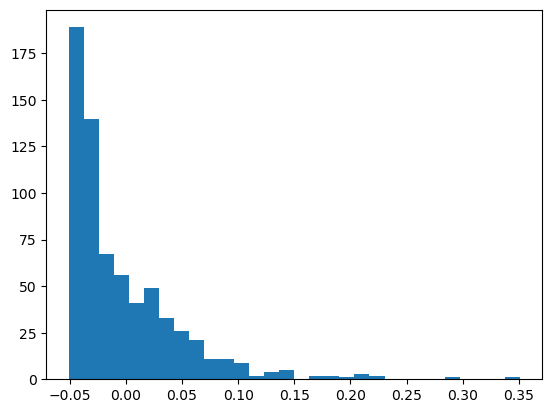

In [107]:
plt.hist((p_c_hat_bal.flatten()-p_c_hat_bal_dhayaa)/p_c_hat_bal.flatten(), bins=30)

In [93]:
np.sum(p_c_hat_bal.flatten())

1.0

In [94]:
np.sum(p_c_hat_bal_dhayaa)

0.9999999999999999

In [51]:
p_c_hat_bal_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_chat_balrog.npy')

In [57]:
p_c_hat_bal_dhayaa-p_c_hat_bal.flatten()

array([-2.16840434e-18,  2.38524478e-18,  3.03576608e-18,  2.16840434e-18,
        1.95156391e-18,  3.36102673e-18,  2.38524478e-18,  3.36102673e-18,
        2.81892565e-18,  4.33680869e-18,  1.30104261e-18,  1.19262239e-18,
        3.14418630e-18, -1.38777878e-17,  3.68628739e-18,  3.03576608e-18,
        2.16840434e-19, -1.08420217e-17, -6.93889390e-18, -2.60208521e-18,
       -7.80625564e-18, -2.16840434e-18,  1.95156391e-18,  2.81892565e-18,
        2.16840434e-18,  6.50521303e-19,  6.50521303e-19,  1.51788304e-18,
        1.73472348e-18,  3.68628739e-18,  4.33680869e-18,  4.01154804e-18,
        3.68628739e-18,  1.62630326e-18,  2.71050543e-18,  2.60208521e-18,
        2.92734587e-18,  1.95156391e-18,  5.42101086e-19, -7.80625564e-18,
        3.03576608e-18,  3.68628739e-18,  2.81892565e-18,  3.03576608e-18,
        2.60208521e-18,  3.46944695e-18,  4.33680869e-19,  2.16840434e-18,
        2.60208521e-18,  2.49366500e-18,  3.03576608e-18,  3.25260652e-18,
        2.81892565e-18,  

In [58]:
p_cchat-p_cchat_dhayaa

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
p_cchat/=np.sum(p_cchat)

In [52]:
p_cchat_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_c_chat.npy')

In [74]:
p_cchat_dhayaa.shape

(676, 2304)

In [82]:
np.allclose(p_cchat_dhayaa, p_cchat)

False

In [84]:
p_cchat

array([[1.77348804e-05, 7.33041723e-05, 7.09395216e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.41879043e-05, 8.86744020e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.71091195e-05, 1.01342174e-05, 6.44904742e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [83]:
p_cchat_dhayaa

array([[2.36889781e-05, 3.67407393e-05, 2.59447267e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.56398673e-05, 1.13724012e-05, 9.70549307e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.96027030e-05, 2.01062302e-05, 1.08459632e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.41184909e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.41184909e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [59]:
p_c_g_chat_mine = p_cchat/p_c_hat_bal.flatten()[:,None]

In [57]:
p_c_g_chat_mine/=np.sum(p_c_g_chat_mine, axis=0)

In [58]:
p_c_g_chat_mine

array([[0.01484924, 0.04487438, 0.00503503, ..., 0.        , 0.        ,
        0.        ],
       [0.02482625, 0.01134449, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04330801, 0.00864712, 0.00638001, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

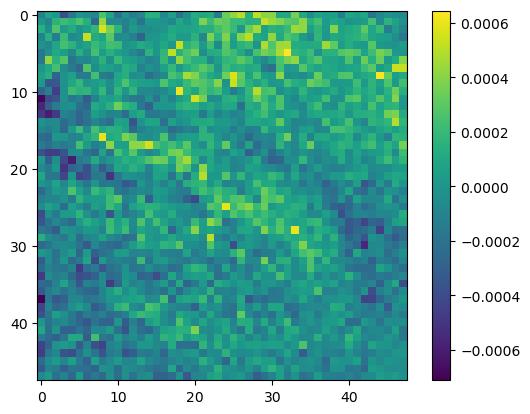

In [27]:
#testing whether these match
p_c_marg = np.sum(p_cchat, axis=0)#.reshape(n_deep,n_deep)
p_c_marg /= np.sum(p_c_marg)

p_c_norm = p_c/np.sum(p_c)#[:,None]

plt.imshow((p_c_marg-p_c_norm.flatten()).reshape(n_deep,n_deep))
plt.colorbar()

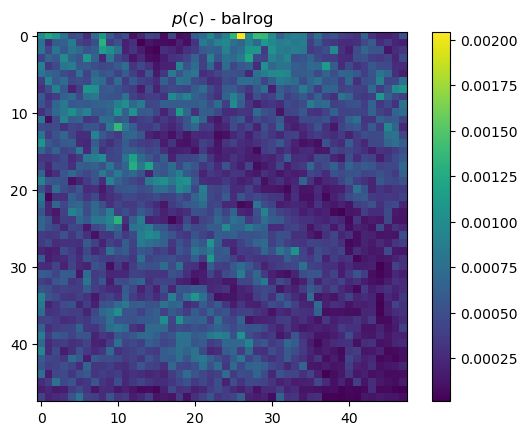

In [28]:
plt.title('$p(c)$ - balrog')
plt.imshow(p_c_marg.reshape(n_deep,n_deep))
plt.colorbar()

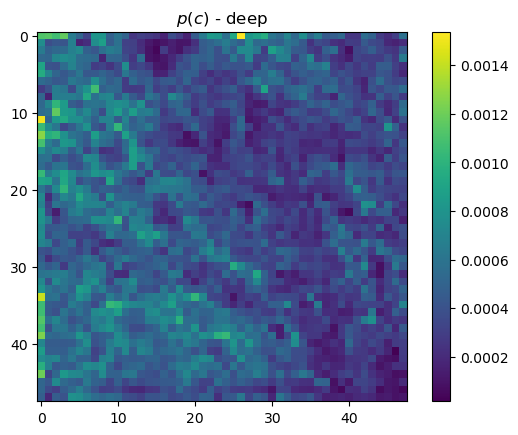

In [29]:
plt.title('$p(c)$ - deep')
plt.imshow(p_c)
plt.colorbar()

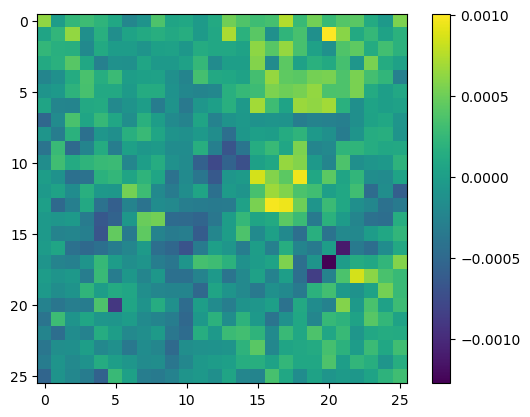

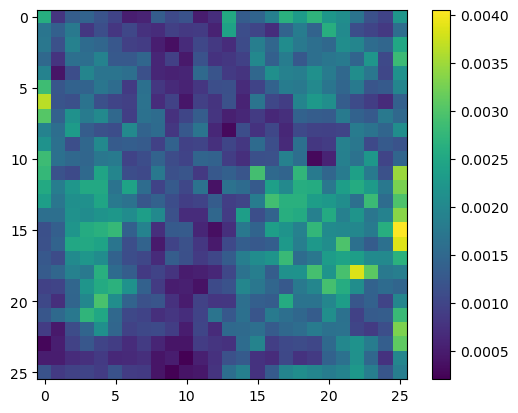

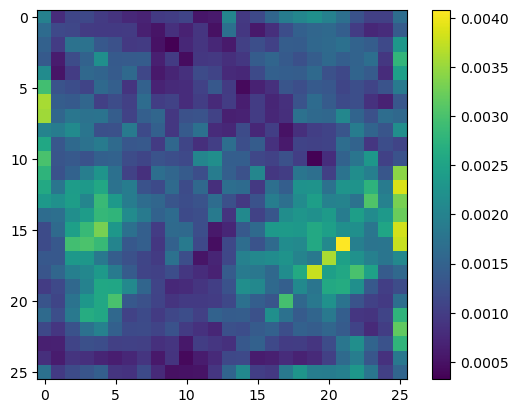

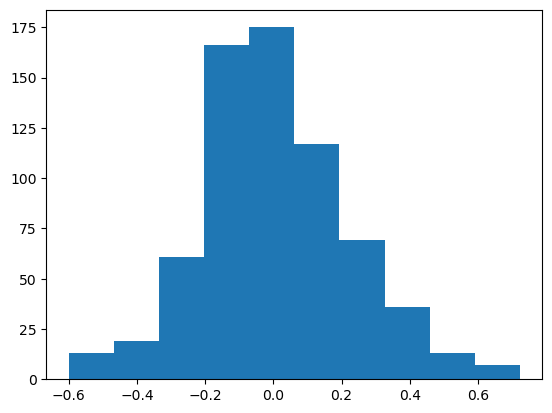

In [30]:
#testing whether these match
p_c_hat_marg = np.sum(p_cchat, axis=1)
p_c_hat_marg /= np.sum(p_c_hat_marg)

p_c_hat_norm = p_c_hat/np.sum(p_c_hat)

plt.imshow((p_c_hat_marg-p_c_hat_norm.flatten()).reshape(n_wide,n_wide))
plt.colorbar()
plt.show()
plt.imshow((p_c_hat_marg.flatten()).reshape(n_wide,n_wide))
plt.colorbar()
plt.show()
plt.imshow((p_c_hat_norm.flatten()).reshape(n_wide,n_wide))
plt.colorbar()
plt.show()
plt.hist((p_c_hat_marg-p_c_hat_norm.flatten())/(p_c_hat_norm.flatten()))
plt.show()

### $p(z|\hat{c}) = \sum_{c} p(z|c) p(c) \dfrac{p(c,\hat{c})}{p(c)p(\hat{c})} p(\hat{c})$

In [168]:
np.array([cell_z['Z'][cell] for cell in cell_z['Z'].index]).shape

(2304, 49)

In [188]:
w_c.w.values[int(0)]

158.0

In [203]:
w_c

,w
deep_cell,
0.0,158.0
1.0,167.0
2.0,172.0
3.0,168.0
4.0,98.0
...,...
2299.0,30.0
2300.0,16.0
2301.0,21.0


In [191]:
# #cell weights
# joint_cell_weight = p_c.flatten() * balrog_term #* p_c_hat.flatten()[:,None]

# #p(z,c)
# cell_z = InjDF[['Z', 'deep_cell', 'w']].groupby('deep_cell').agg(func=hist)
# w_c = InjDF[['deep_cell', 'w']].groupby('deep_cell').sum('w') #w is 1/Ninj, not lensing/shear weights
# p_z_c = np.array([(w_c.w.values[int(cell)]*np.array(cell_z['Z'][int(cell)])) for cell in cell_z['Z'].index])

# zero_mask = np.sum(p_z_c, axis=1)==0
# rangedeep = np.arange(0, n_deep**2)
# nonzero_indices = rangedeep[~zero_mask]

# #p_z_c = p_z_c[nonzero_indices].astype('float64')
# p_z_c = p_z_c.astype('float64')
# p_z_c_norm_factor = np.sum(p_z_c, axis=1)[:,None]
# p_z_c = p_z_c/np.where(p_z_c_norm_factor>0, p_z_c_norm_factor, 1)

# #inner sum result of eq. 14 in Myles, Alarcon
# #p_z_c_hat = (joint_cell_weight[:,nonzero_indices]@p_z_c) #check if should be normalized
# p_z_c_hat = (joint_cell_weight@p_z_c) #check if should be normalized

# #p_z_c_hat /= np.sum(p_z_c_hat, axis=1)[:,None]

In [232]:
InjDF

,ID,wide_cell,deep_cell,N_inj,w,Z
0,698419852,457.0,NaN,14,0.071429,NaN
1,692279852,0.0,NaN,8,0.125000,NaN
2,712517969,0.0,1525.0,13,0.076923,0.539
3,713086105,NaN,NaN,3,0.333333,NaN
4,712734329,0.0,2092.0,15,0.066667,0.729
...,...,...,...,...,...,...
3760722,697511269,312.0,NaN,4,0.250000,NaN
3760723,692009091,NaN,NaN,4,0.250000,NaN
3760724,692269134,665.0,2042.0,5,0.200000,NaN
3760725,712910796,440.0,NaN,25,0.040000,NaN


In [297]:
#cell weights
joint_cell_weight = p_c.flatten() * balrog_term #* p_c_hat.flatten()[:,None]

#p(z,c)
cell_z = InjDF[sel_mask][['Z', 'deep_cell', 'w']].groupby('deep_cell').apply(func=hist)
#w_c = InjDF[['deep_cell', 'w']].groupby('deep_cell').sum('w') #w is 1/Ninj, not lensing/shear weights
p_z_c = np.array([cell_z[int(cell)] for cell in cell_z.index])

zero_mask = np.sum(p_z_c, axis=1)==0
rangedeep = np.arange(0, n_deep**2)
#nonzero_indices = rangedeep[~zero_mask]

#p_z_c = p_z_c[nonzero_indices].astype('float64')
p_z_c = p_z_c.astype('float64')
p_z_c_norm_factor = np.sum(p_z_c, axis=1)[:,None]
p_z_c = p_z_c/np.where(p_z_c_norm_factor>0, p_z_c_norm_factor, 1)

#inner sum result of eq. 14 in Myles, Alarcon
#p_z_c_hat = (joint_cell_weight[:,nonzero_indices]@p_z_c) #check if should be normalized
p_z_c_hat = (joint_cell_weight@p_z_c) #check if should be normalized

#p_z_c_hat /= np.sum(p_z_c_hat, axis=1)[:,None]

In [280]:
p_z_c_hat/=np.sum(p_z_c_hat, axis=1)[:,None]

In [281]:
np.sum(p_z_c_hat)

675.9999999999999

In [121]:
np.isfinite(p_z_c).all()

True

In [122]:
p_z_c.shape

(2304, 49)

In [98]:
np.array([cell_z['Z'][cell] for cell in cell_z['Z'].index]).shape

(2304, 49)

In [88]:
np.unique(balrog_deep['ID'])

(676683,)

In [86]:
deep

,ID,RA,DEC,KNN_CLASS,BDF_FLUX_DERED_CALIB_U,BDF_FLUX_DERED_CALIB_G,BDF_FLUX_DERED_CALIB_R,BDF_FLUX_DERED_CALIB_I,BDF_FLUX_DERED_CALIB_Z,BDF_FLUX_DERED_CALIB_J,...,BDF_MAG_DERED_CALIB_I,BDF_MAG_ERR_DERED_CALIB_I,BDF_MAG_DERED_CALIB_Z,BDF_MAG_ERR_DERED_CALIB_Z,BDF_MAG_DERED_CALIB_J,BDF_MAG_ERR_DERED_CALIB_J,BDF_MAG_DERED_CALIB_H,BDF_MAG_ERR_DERED_CALIB_H,BDF_MAG_DERED_CALIB_KS,BDF_MAG_ERR_DERED_CALIB_KS
0,692581197,52.919675,-28.867296,1.0,204.186270,259.924072,640.058928,923.667161,990.715877,1470.225204,...,22.586211,26.952407,22.510127,26.342617,22.081540,26.050102,22.165696,25.182028,21.740549,25.628577
1,692581245,52.806489,-28.867570,1.0,482.933499,471.033683,666.071153,1136.945773,1345.197659,1742.870626,...,22.360651,26.856650,22.178035,26.252879,21.896837,25.935484,21.842756,25.462827,21.771434,25.590632
2,692581291,52.847828,-28.869228,1.0,1094.144134,1352.384103,2619.408382,4579.472224,5198.553619,7106.616134,...,20.847961,26.262921,20.710294,25.694937,20.370843,25.650495,20.155774,25.193989,20.006329,25.495143
3,692581293,52.856823,-28.870751,1.0,1986.774586,2948.795729,5489.816636,6215.050206,7144.472830,8527.280981,...,20.516388,26.066420,20.365075,25.422847,20.172974,25.824408,20.058638,24.901525,19.988263,25.403221
4,692581435,52.813987,-28.872141,1.0,1707.829727,2646.956330,4638.808679,5388.150997,6078.494828,7333.607844,...,20.671401,26.434858,20.540510,25.839175,20.336706,26.547696,20.237627,25.685083,20.115917,26.104185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144041,698431163,36.978001,-4.969034,1.0,191.622830,656.359471,2309.533102,3801.424896,4924.267036,8947.095761,...,21.050134,26.768454,20.769146,26.242319,20.120795,26.088505,19.796286,25.893768,19.477974,25.518691
144042,698431259,36.954328,-4.969575,1.0,120.250526,216.091623,506.742228,825.888467,965.745010,1440.678393,...,22.707696,26.921087,22.537844,26.399831,22.103582,25.803389,21.890498,25.613382,21.558558,25.398171
144043,698431931,36.889803,-4.975466,1.0,347.428774,524.071173,601.148175,624.480941,659.387098,1004.714485,...,23.011202,27.031072,22.952149,26.454604,22.494893,27.079721,22.192262,26.739844,21.936735,26.426579
144044,698432027,37.016463,-4.977824,1.0,802.635318,1458.256794,2833.101547,3339.585189,3624.605553,4458.817035,...,21.190769,26.408194,21.101848,25.885139,20.876951,26.578990,20.840584,26.199629,20.693199,25.790639


In [92]:
np.unique(cell_z.index).shape

(2304,)

In [65]:
joint_cell_weight 

array([[0.01415556, 0.02195476, 0.0155035 , ..., 0.        , 0.        ,
        0.        ],
       [0.02005694, 0.01458424, 0.01244655, ..., 0.        , 0.        ,
        0.        ],
       [0.02584015, 0.0175507 , 0.00946742, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00158652, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00112093, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [172]:
p_c_hat_bal_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_chat_V3.npy')

In [66]:
p_c

array([0.00207574, 0.00083482, 0.00125253, 0.00125088, 0.0009908 ,
       0.00093721, 0.00073291, 0.0008054 , 0.00113931, 0.00105283,
       0.00112413, 0.00056949, 0.00076268, 0.00242668, 0.00122898,
       0.00143945, 0.00182305, 0.00221837, 0.00220125, 0.00232145,
       0.00214516, 0.00181693, 0.00138799, 0.00112772, 0.00104931,
       0.00184431, 0.00155472, 0.00117138, 0.00122264, 0.00097876,
       0.00107111, 0.00097508, 0.00103301, 0.00071544, 0.00064071,
       0.0009281 , 0.00079529, 0.00094838, 0.00058762, 0.00216706,
       0.00114781, 0.00080159, 0.0009604 , 0.00142134, 0.00164231,
       0.00147986, 0.00175021, 0.00153178, 0.00113788, 0.00095968,
       0.00089559, 0.001484  , 0.00140629, 0.00098557, 0.00172402,
       0.0015938 , 0.00142003, 0.00123311, 0.00101796, 0.00104457,
       0.00058498, 0.00034536, 0.00080943, 0.00099925, 0.00085013,
       0.00068825, 0.00127798, 0.00154071, 0.00136833, 0.00173368,
       0.00159894, 0.00152241, 0.00156783, 0.00180737, 0.00174

In [173]:
joint_cell_weight_norm=joint_cell_weight/np.sum(joint_cell_weight, axis=1)[:,None]

In [175]:
joint_cell_weight_norm-np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_c_given_chat.npy')

array([[-1.56125113e-17, -2.42861287e-17, -1.56125113e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.81639165e-17,  2.94902991e-17,  2.60208521e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.51028104e-17,  3.12250226e-17,  1.73472348e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.95156391e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  8.67361738e-19,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [76]:
np.allclose(joint_cell_weight, np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_c_given_chat.npy'))

True

In [74]:
np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_c_given_chat.npy')

array([[0.0114123 , 0.01770007, 0.01249902, ..., 0.        , 0.        ,
        0.        ],
       [0.01873444, 0.0136226 , 0.01162587, ..., 0.        , 0.        ,
        0.        ],
       [0.02363428, 0.01605246, 0.00865923, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00136062, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00091188, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [63]:
np.allclose(p_c_g_chat_mine,np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_c_given_chat.npy'))

True

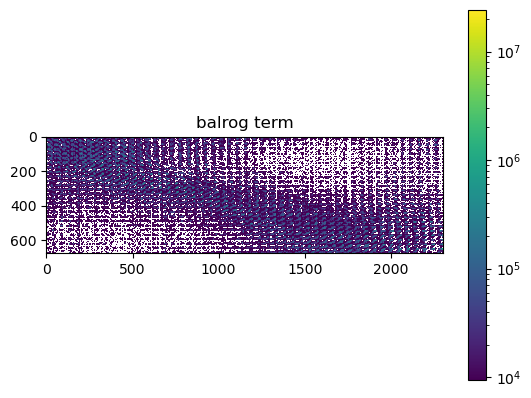

In [32]:
plt.title('balrog term')
plt.imshow(balrog_term, norm=LogNorm())
plt.colorbar()

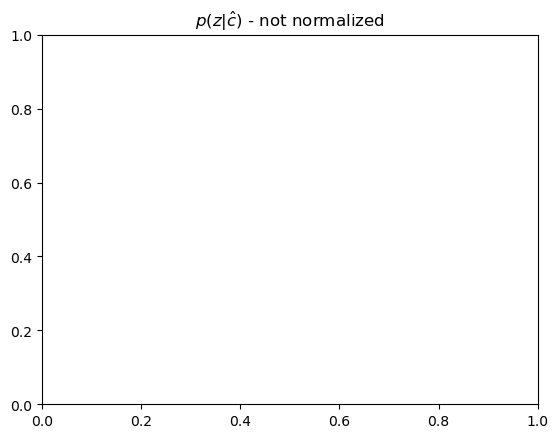

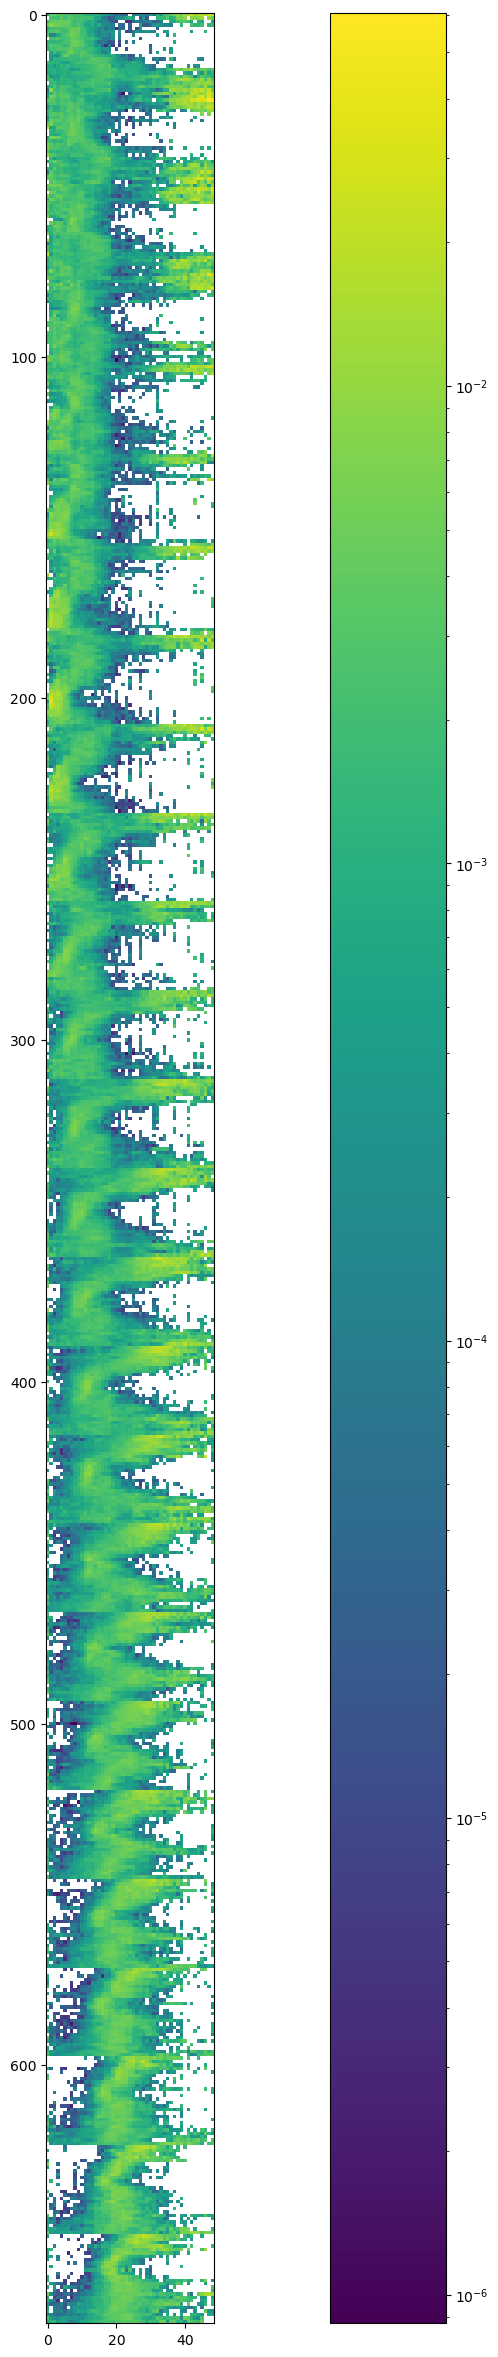

In [ ]:
from matplotlib.colors import LogNorm
plt.title('$p(z|\hat{c})$ - not normalized')
plt.figure(figsize=(30,30))
plt.imshow(p_z_c_hat/np.sum(p_z_c_hat, axis=0), norm=LogNorm())
plt.colorbar()

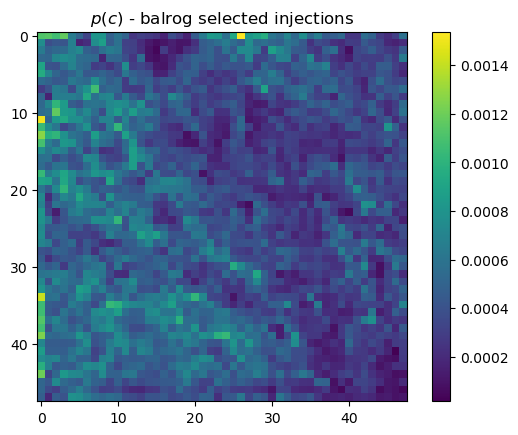

In [30]:
plt.title('$p(c)$ - balrog selected injections')
plt.imshow(p_c)
plt.colorbar()

### Binning algorithm described in Myles, Alarcon 2021

In [31]:
#bins_0 = np.concatenate(([0], np.random.normal([0.358, 0.631, 0.872], scale=.03), [2]))
bins_0 = np.concatenate(([0], [0.358, 0.631, 0.872], [2]))
bins_0 = np.round(bins_0, decimals=3)

In [32]:
n_bins = 4
def tb_share(bins=bins_0):
    bins = np.concatenate(([0], bins, [2]))
    binned_counts = np.zeros((n_bins, N_wide))

    redshifts = (balrog_deep[['Z', 'wide_cells']][balrog_mask_test])
    Zs = redshifts['Z'].values
    bin_masks = [((bins[i]<Zs) & (Zs<bins[i+1])) for i in range(n_bins)]
    bin_groups = [redshifts[bin_masks[i]].groupby('wide_cells').agg([len]) for i in range(n_bins)]
    binned_cell_idx = [np.array(bin_group.Z.index.astype(int)) for bin_group in bin_groups]
    for i in range(n_bins):
        binned_counts[i][binned_cell_idx[i]] = bin_groups[i].Z.len

    tomo_idx = []
    for i in range(n_bins):
        tomo_idx.append(np.arange(N_wide)[np.argmax(binned_counts, axis=0)==i])

    share = [np.sum(counts_wide[tomo_idx[i]]) for i in range(n_bins)]
    norm_share = share/sum(share)
    return norm_share

In [33]:
tb_share(bins=[ 3.670e-01,  6.076e-01,  8.466e-01])

array([0.24979198, 0.25079279, 0.24941099, 0.25000425])

In [ ]:
#print(len(catalog))
Zs = catalog['Z'].values

bin_masks = [((bins[i]<Zs) & (Zs<bins[i+1])) for i in range(n_bins)]
bin_groups = [catalog[bin_masks[i]].groupby('wide_cells').agg([len]) for i in range(n_bins)]
binned_cell_idx = [bin_group.Z.index.astype(int) for bin_group in bin_groups]

bin_lengths = [np.sum(bin_group.Z.len) for bin_group in bin_groups]
tb_norm_counts = np.array([bin_length/np.sum(bin_lengths) for bin_length in bin_lengths])
return np.sum((tb_norm_counts - 0.25)**2)#+np.var(tb_norm_counts)

In [90]:
def bin_loss(bins=bins_0, n_bins=4):
    bins = np.concatenate(([0], bins, [2]))
    binned_counts = np.zeros((n_bins, N_wide))

    redshifts = (balrog_deep[['Z', 'wide_cells']][balrog_mask_test])
    Zs = redshifts['Z'].values
    bin_masks = [((bins[i]<Zs) & (Zs<bins[i+1])) for i in range(n_bins)]
    bin_groups = [redshifts[bin_masks[i]].groupby('wide_cells').agg([len]) for i in range(n_bins)]
    binned_cell_idx = [np.array(bin_group.Z.index.astype(int)) for bin_group in bin_groups]
    for i in range(n_bins):
        binned_counts[i][binned_cell_idx[i]] = bin_groups[i].Z.len

    tomo_idx = []
    for i in range(n_bins):
        tomo_idx.append(np.arange(N_wide)[np.argmax(binned_counts, axis=0)==i])

    share = [np.sum(counts_wide[tomo_idx[i]]) for i in range(n_bins)]
    norm_share = share/sum(share)
    return np.sum((norm_share - 0.25)**2)#+np.var(tb_norm_counts)

In [91]:
%%time
bins_0 = np.random.normal([0.358, 0.631, 0.872], scale=.1)


result_DE = differential_evolution(bin_loss, bounds=[(0,2), (0,2), (0,2)], x0=bins_0)
bins = result_DE.x
print(result_DE)

 message: Optimization terminated successfully.
 success: True
     fun: 1.0187413792343142e-06
       x: [ 3.670e-01  6.076e-01  8.466e-01]
     nit: 64
    nfev: 2929
CPU times: user 5min 27s, sys: 1.61 s, total: 5min 29s
Wall time: 5min 30s


In [ ]:
for i in range(N_wide):
    Sum = np.sum(catalog['wide_cells'].values == i)
    if Sum == 0:
        print(Sum)

In [ ]:
bin_groups = [catalog[bin_masks[i]].groupby('wide_cells').agg([len]) for i in range(4)]
bin_cell_idx = [bin_group.index.astype(int) for bin_group in bin_groups]
[bin_cell_ids for bin_cell_ids in bin_cell_idx]

In [65]:
Zs

7          0.737000
12         0.620605
18         0.645000
20         0.658500
22              NaN
             ...   
3760678    1.113000
3760704         NaN
3760712         NaN
3760715    0.944150
3760716    0.964800
Name: Z, Length: 834737, dtype: float64

[0.     0.367  0.6076 0.8466 2.    ]


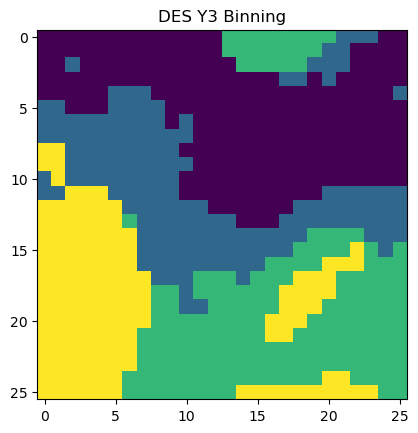

In [244]:
n_bins = 4
N_wide = 26**2
Wide_bins = np.zeros(N_wide, dtype = int).flatten()
#bins = differential_evolution(bin_loss, bounds=[(0,0), (0,1), (0,1), (2,2)], x0= [0, 0.4, 0.8, 2]).x
bins = np.concatenate(([0], [ 3.670e-01,  6.076e-01,  8.466e-01], [2]))
#bins=[0.000e+00,  4.230e-01,  6.738e-01,  9.931e-01,  2.000e+00]
binned_counts = np.zeros((n_bins, N_wide))
catalog = (balrog_deep[['Z', 'wide_cells']][balrog_mask_test])
Zs = catalog['Z']

# bin_masks = [((bins[i]<=Zs) & (Zs<=bins[i+1])) for i in range(4)]
# bin_groups = [catalog[bin_masks[i]].groupby('wide_cells').count() for i in range(4)]
# binned_cell_idx = [bin_group.Z.index.astype(int) for bin_group in bin_groups]
for i in range(N_wide):
    Balrog_in_this_cell = catalog['wide_cells'].values == i
    redshift_in_this_cell = catalog['Z'].values[Balrog_in_this_cell] #Deep/true Redshift of all gals in this cell
    bcounts_in_this_cell  = np.histogram(redshift_in_this_cell, bins)[0] #How many deep galaxy counts per z-bin
    Wide_bins[i]          = np.argmax(bcounts_in_this_cell) #Which bin is most populated by galaxies from this cell?

# for i in range(4):
#     binned_counts[i][binned_cell_idx[i]]=bin_groups[i].Z.values

# tomo_bins = np.argmax(binned_counts.T, axis=1)

#np.savez('/project/chihway/raulteixeira/data/TomoBins_DESY3_Algo_DELVE_DR3_1_1.npz', tomo_bins)
print(bins)
plt.title('DES Y3 Binning')
plt.imshow(Wide_bins.reshape(n_wide, n_wide))

In [29]:
balrog_deep[balrog_mask_test].to_hdf('%s/for_dhayaa_v2.hdf5'%outpath, key='df')

/tmp/jobs/31425712/ipykernel_260678/3107419873.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->bytes,key->block6_values] [items->Index(['tilename'], dtype='object')]

  balrog_deep[balrog_mask_test].to_hdf('%s/for_dhayaa_v2.hdf5'%outpath, key='df')


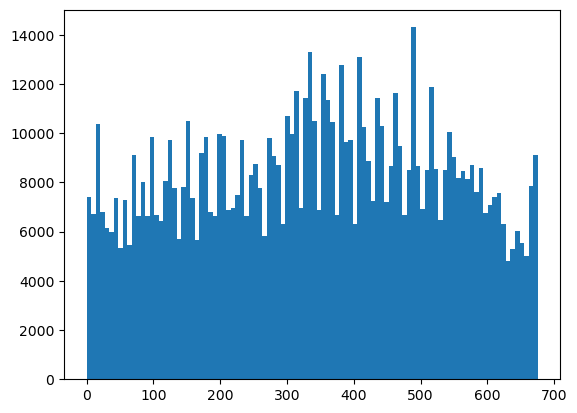

In [125]:
plt.hist(balrog_deep['wide_cells'][balrog_mask_test], bins=100)
plt.show()

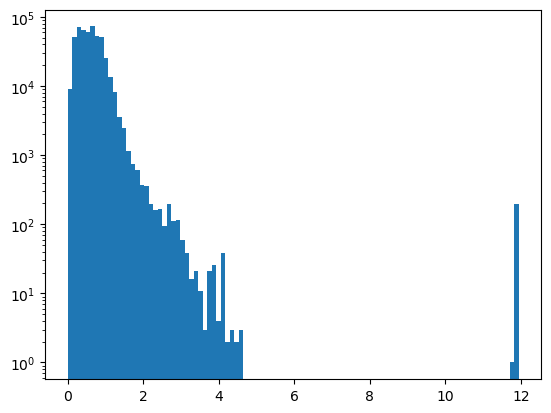

In [143]:
plt.hist(balrog_deep['Z'][balrog_mask_test], bins=100, log=1)
plt.show()

In [132]:
balrog_deep[balrog_mask_test].to_hdf('%s/for_dhayaa.hdf5'%outpath, key='df')

/tmp/jobs/31425310/ipykernel_249961/2150431785.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->bytes,key->block6_values] [items->Index(['tilename'], dtype='object')]

  balrog_deep[balrog_mask_test].to_hdf('%s/for_dhayaa.hdf5'%outpath, key='df')


In [ ]:
# SOMsize   = int(np.ceil(np.sqrt(Balrog_df['cell'].max())))
#         Wide_bins = np.zeros(SOMsize * SOMsize, dtype = int).flatten()
        
#         print(z_bins)
#         for i in tqdm(range(Wide_bins.size), desc = 'Assign chat to bins'):

#             Balrog_in_this_cell = Balrog_df['cell'].values == i #Find all balrog injections in this cell

#             if np.sum(Balrog_in_this_cell) == 0: #If this cell is empty
#                 Wide_bins[i] = -99
#                 continue

#             else:
#                 redshift_in_this_cell = Balrog_df['Z'].values[Balrog_in_this_cell] #Deep/true Redshift of all gals in this cell
#                 bcounts_in_this_cell  = np.histogram(redshift_in_this_cell, z_bins)[0] #How many deep galaxy counts per z-bin
#                 Wide_bins[i]          = np.argmax(bcounts_in_this_cell) #Which bin is most populated by galaxies from this cell?

834737


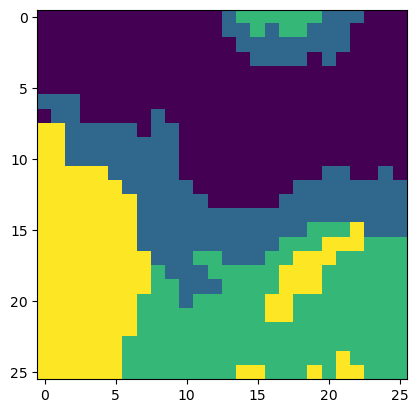

In [243]:
binned_counts = [0.,    0.3767, 0.6343, 0.86,   2.]#np.zeros((n_bins, N_wide))
bins =  [0.,    0.3767, 0.6343, 0.86,   2.]#np.concatenate(([0], result_DE.x, [2]))
catalog = (balrog_deep[['Z', 'wide_cells']][balrog_mask_test])
Wide_bins = np.zeros(N_wide, dtype = int).flatten()

print(len(catalog))
Zs = catalog['Z']
for i in range(N_wide):
    cell_mask_i = catalog['wide_cells'] == i
    redshift_in_this_cell = Zs[cell_mask_i]
    counts_in_this_cell = np.histogram(Zs[cell_mask_i], bins=bins)[0]
    Wide_bins[i]          = np.argmax(counts_in_this_cell)
#     for j in range(4):
#         bin_mask_i_j = ((bins[j]<=Zs) & (Zs<=bins[j+1]))
#         binned_counts[j,i] = len(Zs[bin_mask_i_j&cell_mask_i])
#tomo_bins = np.argmax(binned_counts.T, axis = 1)
plt.imshow(Wide_bins.reshape(n_wide, n_wide))
plt.show()

In [118]:
binned_counts

array([[122687., 122687., 122687., ..., 122687., 122687., 122687.],
       [122690., 122690., 122690., ..., 122690., 122690., 122690.],
       [122701., 122701., 122701., ..., 122701., 122701., 122701.],
       [122681., 122681., 122681., ..., 122681., 122681., 122681.]])

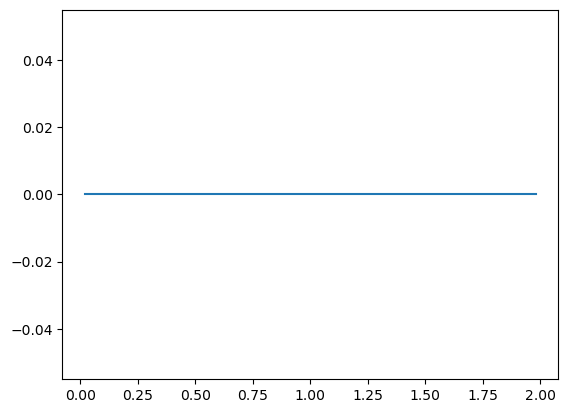

In [236]:
plt.plot(zs, np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_z_given_c_bhat_shat.npy')[0]-p_z_c[0])

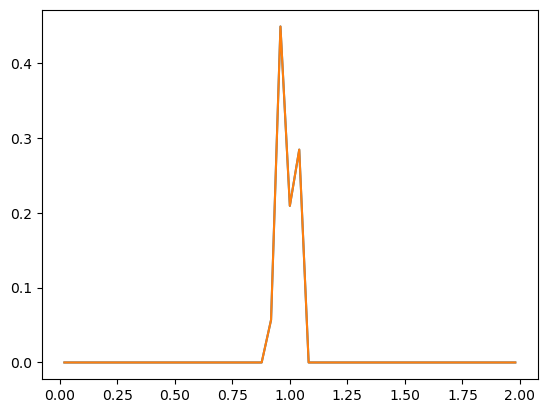

In [235]:
i = 2303
plt.plot(zs, np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_z_given_c_bhat_shat.npy')[i])
plt.plot(zs, p_z_c[i])
plt.show()

In [254]:
p_z_bhat_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_z_given_bhat.npy')

In [242]:
np.allclose(np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_z_given_c_bhat_shat.npy'), p_z_c)

True

In [136]:
p_z_c_hat.shapep_c_hat.flatten().shape

((676, 49), (676,))

In [147]:
(p_c_hat.flatten()[:,None]*p_z_c_hat).shape

(676, 49)

In [145]:
cell_masks[0].shape

(676,)

In [237]:
# n_bins = 4
# cell_masks = [Wide_bins==i for i in range(n_bins)]

# p_z_c_hat_bins = np.array([np.sum(p_z_c_hat[cell_masks[i]], axis=0) for i in range(n_bins)])

# print('mean z per bin', [np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * zs)\
#        for i in range(n_bins)])

mean z per bin [0.35186636962727547, 0.52136270919647, 0.7161919409631515, 0.9102594403924431]


In [282]:
n_bins = 4
cell_masks = [Wide_bins==i for i in range(n_bins)]

p_z_c_hat_bins = np.array([np.sum((p_c_hat.flatten()[:,None]*p_z_c_hat)[cell_masks[i]], axis=0) for i in range(n_bins)])

print('mean z per bin', [np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * zs)\
       for i in range(n_bins)])

mean z per bin [0.3598520676881677, 0.5331227442227201, 0.7107974936348158, 0.9013227735644576]


In [283]:
for i in range(3):
    cov = np.sum(p_z_c_hat_bins[i]*p_z_c_hat_bins[i+1])/np.sum(p_z_c_hat_bins[i])/np.sum(p_z_c_hat_bins[i+1])
    print(f'cov between bin {i} and {i+1}: {cov:.3}')

cov between bin 0 and 1: 0.0541
cov between bin 1 and 2: 0.0366
cov between bin 2 and 3: 0.0399


In [284]:
p_z_c_hat_bins/=np.sum(p_z_c_hat_bins, axis=1)[:,None]

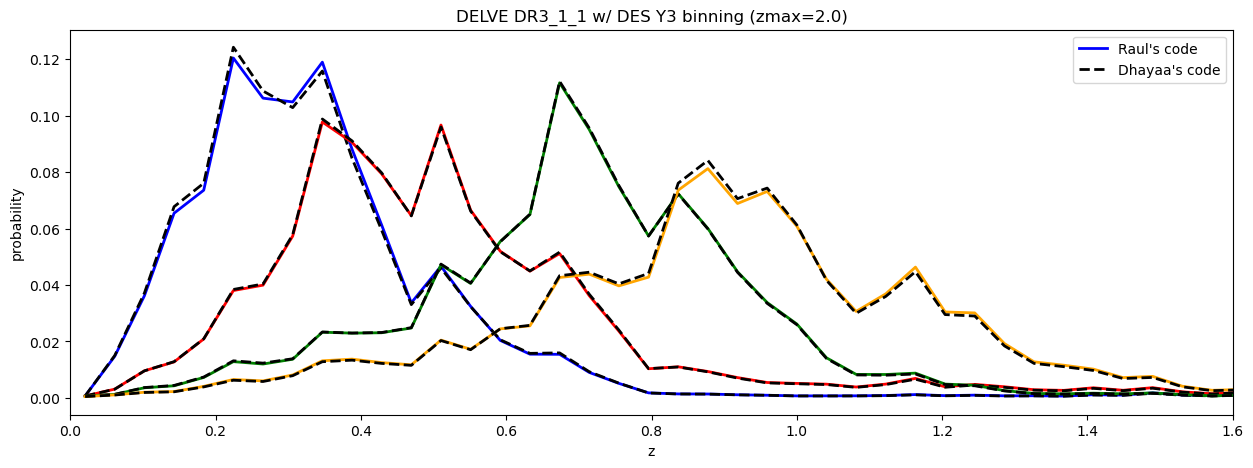

In [304]:
plt.figure(figsize=(15,5))
plt.title(f'DELVE DR3_1_1 w/ DES Y3 binning (zmax={zmax})')
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('probability')
colors = ['blue', 'red', 'green', 'orange']
plt.xticks(ticks=np.arange(0, 1.9, 0.2))
plt.xlim(0,1.6)
for i in range(n_bins):
    plt.plot(zs, p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]), c=colors[i], lw=2, label='Raul\'s code' if i == 0 else None)
    plt.plot(zs, p_z_bhat_dhayaa[i], c='k', lw=2, ls='--', label='Dhayaa\'s code' if i == 0 else None)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


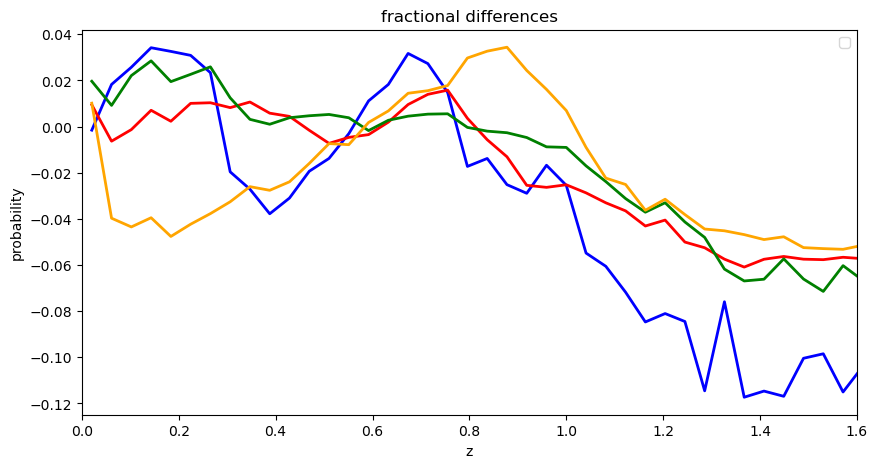

In [316]:
plt.figure(figsize=(10,5))
plt.title(f'fractional differences')
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('probability')
colors = ['blue', 'red', 'green', 'orange']
plt.xticks(ticks=np.arange(0, 1.9, 0.2))
plt.xlim(0,1.6)
for i in range(n_bins):
    plt.plot(zs, (p_z_bhat_dhayaa[i]-(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i])))/(p_z_bhat_dhayaa[i]), c=colors[i], lw=2, label='Raul\'s code' if i == 5 else None)
    #plt.plot(zs, p_z_bhat_dhayaa[i], c='k', lw=2, ls='--', label='Dhayaa\'s code' if i == 0 else None)
plt.legend()

In [306]:
np.save('%s/p_z_c_hat_bins_12142023.npy'%outpath, p_z_c_hat_bins)

In [307]:
print('%s/p_z_c_hat_bins_12142023.npy'%outpath)

/project/chihway/raulteixeira/data//p_z_c_hat_bins_12142023.npy


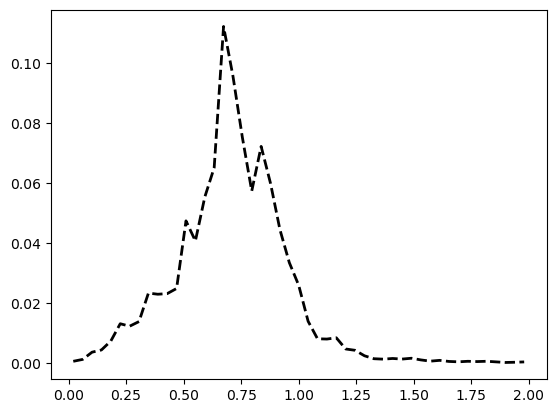

In [264]:
plt.plot(zs, p_z_bhat_dhayaa[2], c='k', lw=2, ls='--')

In [46]:
np.savetxt('%sp_z_c_hat_120823.txt'%outpath, p_z_c_hat_bins)

In [83]:
p_z_c.shape

(2302, 49)

In [59]:
'%s/p_z_c_hat_112823.txt'%outpath

'/project/chihway/raulteixeira/data//p_z_c_hat_112823.txt'

In [49]:
[f'{share:.4}' for share in tb_share(bins=result_DE.x)]

['0.25', '0.25', '0.25', '0.25']

### Deep2Wide plots (sanity checks!)

In [69]:
def group_i_deep(i, max_d, n):
    ps = np.array(np.unravel_index(np.arange(0,n**2), (n,n), order='F'))
    p = np.array(np.unravel_index(i, (n,n), order='F'))
    d = np.sum(np.abs(ps-p[:, None]),axis=0)
    return np.arange(0,n**2)[d<=max_d]

In [70]:

fig, axes = plt.subplots(nx, ny, figsize=(12, 24))
i_deeps = np.random.randint(0,n_deep**2, (nx, ny))
for i_deep in i_deeps:

    idx_deep = group_i_deep(i_deep, max_d=2, n=n_deep)

    plt.title(f'Deep SOM cell: {i_deep-1}')

    im = np.sum(p_cchat[:,idx_deep],axis=1).reshape(n_wide,n_wide)

    im /= np.sum(im)

    plt.title(f'Deep SOM cell: {i_deep-1}')
    plt.imshow(im, norm=mpl.colors.LogNorm())
    plt.colorbar()
    plt.show()

NameError: name 'nx' is not defined